In [1]:
from openseespy.opensees import *
import numpy as np
import opsvis as opsv

In [2]:
wipe()
model('Basic', '-ndm', 2)

In [3]:
# units = kips, ft
numBay = 2
numFloor = 7 
bayWidth = 360.0 #ft
storeyHeights = [162.0, 162.0, 156.0, 156.0, 156.0, 156.0, 156.0] # ft

E = 29500.0 # Modulus of elasticity
massX = 0.49 # mass per unit length, kips/ft
M = 0.
coordTransf =  "Linear" # Linear, PDelta, Corotational
massType = "-lMass" # -lMass, -cMass

In [4]:
beams = ['W24X160', 'W24X160', 'W24X130', 'W24X130', 'W24X110', 'W24X110', 'W24X110']
eColumn = ['W14X246', 'W14X246', 'W14X246', 'W14X211', 'W14X211', 'W14X176', 'W14X176']
iColumn = ['W14X287', 'W14X287', 'W14X287', 'W14X246', 'W14X246', 'W14X211', 'W14X211']
columns = [eColumn, iColumn, eColumn]

In [5]:
WSection = {
    'W14X176': [51.7, 2150.],
    'W14X211': [62.1, 2670.],
    'W14X246': [72.3, 3230.],
    'W14X287': [84.4, 3910.],
    'W24X110': [32.5, 3330.],
    'W24X130': [38.3, 4020.],
    'W24X160': [47.1, 5120.]
}

In [6]:
nodeTag = 1
yLoc = 0
for i in range(numFloor+1): # 0,1,2,3,4,5,6,7
    xLoc = 0
    for _ in range(numBay+1):
        node(nodeTag, xLoc, yLoc)
        nodeTag += 1
        xLoc += bayWidth
    if i < len(storeyHeights):
        storeyHeight = storeyHeights[i]
        yLoc += storeyHeight

In [7]:
# Fix the base nodes
fix(1, 1, 1, 1)
fix(2, 1, 1, 1)
fix(3, 1, 1, 1)

In [8]:
# Define a function to make element
def makeElasticBeamColumnElement(eleTag, iNode, jNode, sectType, E, transTag, M, massType):
    prop = WSection[sectType]
    A = prop[0]
    I = prop[1]
    element('elasticBeamColumn', eleTag, iNode, jNode, A, E, I, transTag, '-mass', M, massType)

<Axes: >

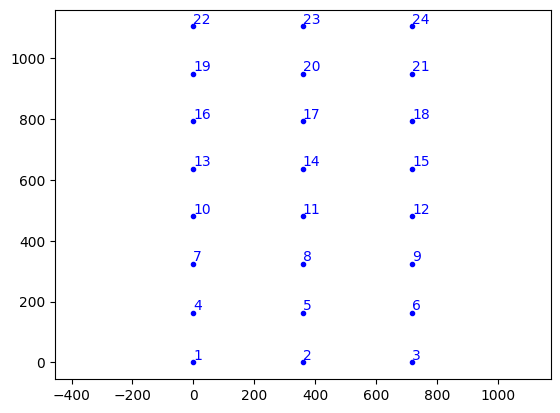

In [9]:
opsv.plot_model()

In [10]:
geomTransf(coordTransf, 1)

In [11]:
# Add column
eleTag = 1
for j in range(numFloor):
    end1 = (numBay + 1) * j + 1
    for i in range(numBay+1):
        end2 = end1 + (numBay + 1)
        sectType = columns[i][j]
        makeElasticBeamColumnElement(eleTag, end1, end2, sectType, E, 1, M, massType)
        eleTag += 1
        end1 += 1

In [12]:
# Add beams
for j in range(1, numFloor+1):
    sectType = beams[j-1]
    end1 = (numBay + 1) * j + 1
    end2 = end1 + 1
    for _ in range(numBay):
        makeElasticBeamColumnElement(eleTag, end1, end2, sectType, E, 1, M, massType)
        eleTag += 1
        end1 = end2
        end2 = end1 + 1

<Axes: >

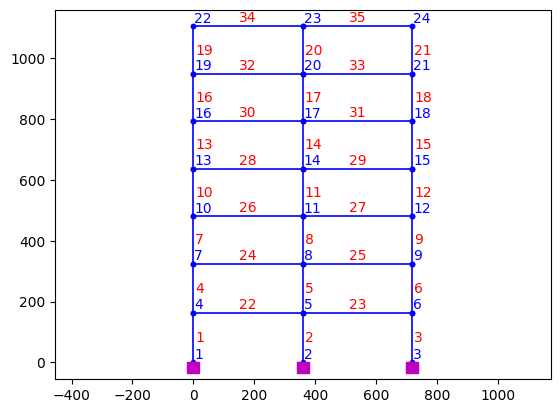

In [13]:
opsv.plot_model()

In [14]:
# Rigid Floor Constraint
for j in range(1, numFloor+1):
    rNode = (numBay + 1) * j + 2
    cNode = rNode - 1
    mass(rNode, massX, 1.0e-10, 1.0e-10)
    for _ in range(numBay):
        equalDOF(rNode, cNode, 1)
        cNode = rNode + 1

In [15]:
# Calculate eigen values
numEigen = 7
eigenValues = eigen(numEigen)
print("The time periods are:")
for i in range(len(eigenValues)):
    lamb = eigenValues[i]
    period = 2 * np.pi / np.sqrt(lamb)
    print(f"{period:.5f} sec")

The time periods are:
1.27321 sec
0.43128 sec
0.24204 sec
0.16018 sec
0.11899 sec
0.09506 sec
0.07951 sec


In [16]:
# apply loads for static analysis & perform analysis
timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(22, 20.0, 0., 0.)
load(19, 15.0, 0., 0.)
load(16, 12.5, 0., 0.)
load(13, 10.0, 0., 0.)
load(10, 7.5, 0., 0.)
load(7, 5.0, 0., 0.)
load(4, 2.5, 0., 0.)

In [17]:
integrator('LoadControl', 1.0)
algorithm('Linear')
analysis('Static')
analyze(1)

0

In [18]:
topDisp = nodeDisp(22, 1)
print(f"Roof displacement = {topDisp:.3f} ft.")

Roof displacement = 1.451 ft.


In [19]:
forces = eleResponse(1, 'forces')
print(f"Axial force in element 1 = {forces[1]:.3f} kips and Moment in element 1 = {forces[2]:.3f} kips.ft.")

Axial force in element 1 = -69.987 kips and Moment in element 1 = 2324.677 kips.ft.


76.0982022409854

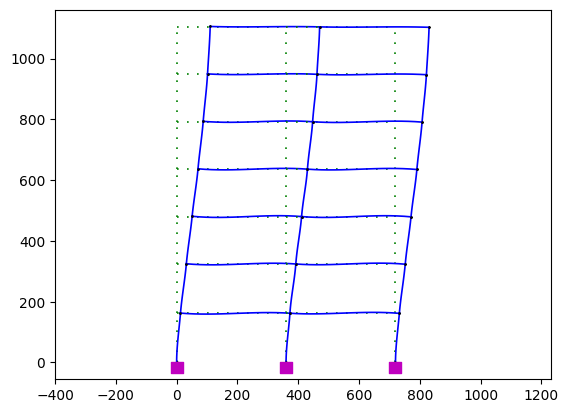

In [20]:
opsv.plot_defo()

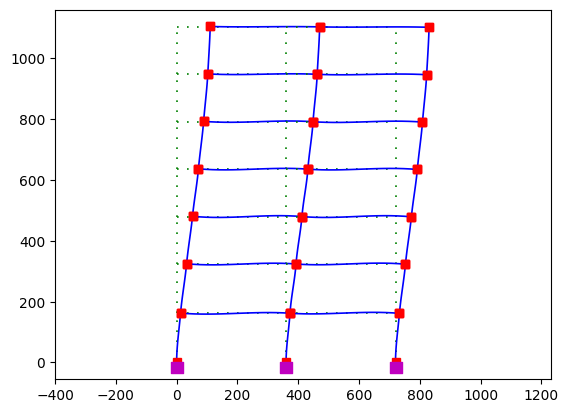

In [21]:
opsv.plot_mode_shape(1)